In [1]:
from utilities import *
from config import *
from data_preparing import *
from DNN_model import *
#import tsfresh
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters
from tsfresh import feature_extraction
from tsfresh import extract_features
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.decomposition import PCA
import tsfresh
from tsfresh import feature_selection
from tsfresh import extract_features, select_features

In [2]:
set_seed(612)
device=CFG.device
CFG.epoches=350

In [3]:
attribute = ['Unit','Time','T24','T30','T50','P30','Nc','Ps30','phi','BPR']
df_train = pd.read_csv('./Dataset 4/preprocessed data/train_data.csv',
                      names = attribute, header = None) 
df_test = pd.read_csv('./Dataset 4/preprocessed data/test_data.csv',
                      names = attribute, header = None) 

train_label=pd.read_csv('./Dataset 4/preprocessed data/train_label.csv', header=None).values
test_label=pd.read_csv('./Dataset 4/preprocessed data/test_label.csv', header=None).values

train_dataset=AircraftDataset(df_train,train_label,attribute[2:]) # 不插0计算创建dataset的子类
test_dataset = AircraftDataset(df_test,test_label,attribute[2:])

train_dataset_expend=AircraftDataset_expend(df_train,train_label,
                                            False,attribute[2:]) # 构建切割后的训练集

# 原始RUL & mode
RUL = pd.read_csv('./Dataset 4/preprocessed data/RUL.csv',
                      names = None, header = None).values.reshape(-1)

lifetime_list=[]
for i in range(len(test_dataset)):
    lifetime=test_dataset[i]["lifetime"].item()
    lifetime_list.append(lifetime)
lifetime_list=np.array(lifetime_list)

In [4]:
set_seed(612)
device=CFG.device
CFG.epoches=350
train_extracted_minmax_large=np.load("./train004/numpy/train_extracted_minmax_train_0419.npy")
test_extracted_minmax_large=np.load("./train004/numpy/test_extracted_minmax_train_0419.npy")
longlist=np.concatenate((train_extracted_minmax_large,test_extracted_minmax_large),axis=\
                        0)[:,np.random.permutation(100)]
train_extracted_minmax_large,test_extracted_minmax_large=np.vsplit(longlist,np.array([48799]))
train_dataset_expend_encoded = AircraftDataset_expend_feature_extraction(df_train, 
                                                                         train_label, 
                                                                         torch.FloatTensor(train_extracted_minmax_large),False,
                                                                        attribute[2:])
train_encoded_loader = DataLoader(
    train_dataset_expend_encoded,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
)
test_dataset = AircraftDataset_no_expend_feature_extraction(df_test, test_label, 
                                                            torch.FloatTensor(test_extracted_minmax_large),attribute[2:])
test_encoded_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False)
for train_data in train_encoded_loader:None
for test_data in test_encoded_loader:None

# no cls

In [5]:
def fit_his_unit(train_loader,path, RESUME=False, shared=True, attention=True, expand=True):
    model=AML_model(100,100,100,128,2,25,shared=shared,attention=attention,expand = expand).to(device)
    #model=AML_model(99,99,99).to(device)
    optimizer = getattr(torch.optim, CFG.optimizer)(model.parameters(), lr=CFG.lr)  # 优化器
    scheduler = getattr(torch.optim.lr_scheduler, CFG.scheduler)(optimizer, gamma=CFG.sc_Gamma)  # 指数型学习率
    start_epoch=-1
    if RESUME:
        path_checkpoint = path+'/ckpt.pth'   # 断点路径
        checkpoint = torch.load(path_checkpoint)  # 加载断点

        model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数

        optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
        start_epoch = checkpoint['epoch']  # 设置开始的epoch
        scheduler.load_state_dict(checkpoint['scheduler'])


    for epoch in range(start_epoch+1,CFG.epoches):
        for data in train_loader:
            if attention:
                pred_batch = model(data["input"].to(device))[0]
            elif not attention:
                pred_batch = model(data["input"].to(device))
            target_batch = data["RUL"].unsqueeze(-1).to(device)
            loss = F.mse_loss(pred_batch, target_batch.float())
        # loss = loss_function(pred_batch, target_batch, train_data, test_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        # scheduler.step(loss,last_loss)
        # last_loss = loss
        if CFG.print_training_process and epoch % 100 == 0:
            print(f"epoch:{epoch}, loss:{loss.item()},lr:{optimizer.state_dict()['param_groups'][0]['lr']}")
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                'scheduler': scheduler.state_dict()
            }
            if not os.path.isdir(path):
                os.mkdir(path)
            torch.save(checkpoint,
                       path+'/ckpt.pth')
        if loss.mean() < 64:
            save_model_weights(model, "model_his.pt",
                               cp_folder=path)
            break
        elif epoch == (CFG.epoches - 1):
            print(f"epoch:{epoch}, loss:{loss.item()}")
            save_model_weights(model, "model_his.pt",
                               cp_folder=path)

In [14]:
set_seed(510)
fit_his_unit(train_encoded_loader,"./train004/model_checkpoints_at", RESUME=False, shared=False, attention=True,expand=False)

epoch:0, loss:2068.864501953125,lr:0.09772512378214518

 -> Saving weights to ./train004/model_checkpoints_at\model_his.pt



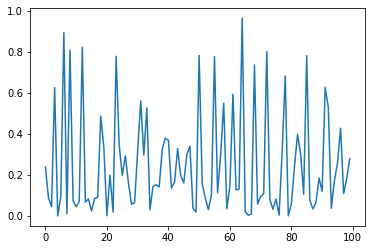

In [22]:
aml_model=AML_model(100,100,100,128,2,25,shared=False,attention=True,expand = False).to(device)
aml_model.load_state_dict(torch.load("./train004/model_checkpoints_at/model_his.pt"))
plt.plot(aml_model(train_data["input"].to(device))[1].cpu().detach().numpy())

In [23]:
pred_1=[]
for idx,test_data in enumerate(test_encoded_loader):
    pred_1_q=aml_model(test_data["input"].to(device))[0].item()
    pred_1.append(pred_1_q)
#RUL

np.sum(np.ceil((abs(np.array(pred_1)-RUL))))#目测结果

6780.0

In [24]:
def get_Accuracy(hat_RUL, RUL_true, lifetime_list):
    """

    :return: RUL升序排序后前20个，前40个，前**个的误差
    """
    # hat_RUL = get_RUL(mu_Gamma, C_Gamma, sigma_2, w, data, data_train)
    # RUL_frame = pd.read_csv(path, header=None)
    # RUL = RUL_frame.values[:, 0]
    length = len(RUL_true)
    Accuracy = np.zeros((length, 2))
    Accuracy[:, 0] = RUL_true
    Accuracy[:, 1] = abs(hat_RUL - RUL_true) / (lifetime_list + RUL_true)
    num_A = np.argsort(Accuracy[:, 0])
    iAccuracy = np.zeros((length, 2))
    for ia in range(0, length):
        iAccuracy[ia, 0] = Accuracy[int(num_A[ia]), 0]
        iAccuracy[ia, 1] = Accuracy[int(num_A[ia]), 1]
    rul0 = [25, 50, 75, 100, 125, 300]
    Accuracy_RUL = np.mat(np.zeros((6, 3)))
    for ir in range(0, 6):
        Accuracy_RUL[ir, 0] = int(rul0[ir])
        num_rul = np.argwhere((iAccuracy[:, 0] <= rul0[ir]))
        #(cycletime_sim_raw > 50) & (cycletime_sim_raw < 350)
        Accuracy_RUL[ir, 1] = np.mean(iAccuracy[num_rul[:, 0], 1])
        s_error = np.std(iAccuracy[num_rul[:, 0], 1])/math.sqrt(len(num_rul))
        Accuracy_RUL[ir, 2] = s_error
    Accuracy_RUL[5, 0] = 150
    return Accuracy_RUL

In [25]:
get_Accuracy(np.array(pred_1), RUL,lifetime_list)

matrix([[2.50000000e+01, 3.72945160e-02, 4.18090983e-03],
        [5.00000000e+01, 4.04993191e-02, 3.59162418e-03],
        [7.50000000e+01, 5.24116161e-02, 5.85067270e-03],
        [1.00000000e+02, 6.84007270e-02, 7.37070931e-03],
        [1.25000000e+02, 8.42170464e-02, 9.35672002e-03],
        [1.50000000e+02, 1.16230339e-01, 9.33573453e-03]])

# have cls

In [21]:
def fit_AML_model2(train_loader,path, num_head,RESUME=False,shared=False, attention=True, expand=False):
    model=AML_model2(100,100,100,128,2,num_head,shared=shared,attention=attention,expand = expand,
                    fix_mode_part=False).to(device)
    #model.load_state_dict(torch.load("./model_checkpoints_at/model_his_aml_cls.pt"))
    #model=AML_model(99,99,99).to(device)
    optimizer = getattr(torch.optim, CFG.optimizer)(filter(lambda p: p.requires_grad, model.parameters()), 
                                                    lr=CFG.lr,weight_decay=0.1)  # 优化器
    scheduler = getattr(torch.optim.lr_scheduler, CFG.scheduler)(optimizer, gamma=CFG.sc_Gamma)  # 指数型学习率
    start_epoch=-1
    if RESUME:
        path_checkpoint = path+'/ckpt_aml.pth'   # 断点路径
        checkpoint = torch.load(path_checkpoint)  # 加载断点

        model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数

        optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
        start_epoch = checkpoint['epoch']  # 设置开始的epoch
        scheduler.load_state_dict(checkpoint['scheduler'])


    for epoch in range(start_epoch+1,CFG.epoches):
        for data in train_loader:
            if attention:
                y_pred,cls_pred,weight_list=model(train_data["input"].to(device))
            else:
                y_pred,cls_pred=model(train_data["input"].to(device))
            y_pred=y_pred.unsqueeze(-1)
            y_target=train_data["RUL"].to(device).unsqueeze(-1).float()
            #y_target=train_data["RUL"].to(device).float()
            cls_target=train_data["mode"].to(device)
#             y_pred_=y_pred[torch.where(y_target>300)]
#             y_target_=y_target[torch.where(y_target>300)]
            loss=F.mse_loss(y_pred,y_target)+10*(-torch.sum(cls_pred*cls_target)/len(cls_pred)) #+\
                        #3 * F.mse_loss(y_pred_,y_target_)
        # loss = loss_function(pred_batch, target_batch, train_data, test_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        # scheduler.step(loss,last_loss)
        # last_loss = loss
        if CFG.print_training_process and epoch % 100 == 0:
            print(f"epoch:{epoch}, loss:{loss.item()},lr:{optimizer.state_dict()['param_groups'][0]['lr']}")
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                'scheduler': scheduler.state_dict()
            }
            if not os.path.isdir(path):
                os.mkdir(path)
            torch.save(checkpoint,
                       path+'/ckpt_aml.pth')
        if loss.mean() < CFG.jump_out_value:
            save_model_weights(model, "model_his_aml.pt",
                               cp_folder=path)
            break
        elif epoch == (CFG.epoches - 1):
            print(f"epoch:{epoch}, loss:{loss.item()}")
            save_model_weights(model, "model_his_aml.pt",
                               cp_folder=path)

In [87]:
set_seed(6510)
fit_AML_model2(train_encoded_loader,"./train004/model_checkpoints_at",num_head=10,RESUME=False,shared=False, 
               attention=True,expand=False)

epoch:0, loss:1852.146484375,lr:0.09772512378214518

 -> Saving weights to ./train004/model_checkpoints_at\model_his_aml.pt



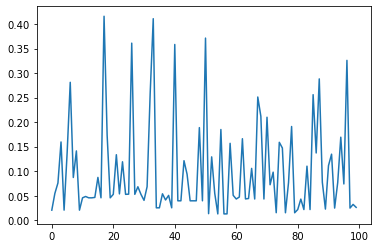

In [88]:
aml_model_2=AML_model2(100,100,100,128,2,10,shared=False, attention=True,expand=False).to(device)
aml_model_2.load_state_dict(torch.load("./train004/model_checkpoints_at/model_his_aml.pt"))
plt.plot(aml_model_2(train_data["input"].to(device))[2][1].cpu().detach().numpy())

In [89]:
pred_2=[]
for idx,test_data in enumerate(test_encoded_loader):
    pred_2_q=aml_model_2(test_data["input"].to(device))[0].item()
    pred_2.append(pred_2_q)
#RUL
np.sum(np.ceil((abs(np.array(pred_2)-RUL))))#目测结果

6140.0

In [90]:
get_Accuracy(np.array(pred_2), RUL,lifetime_list)

matrix([[2.50000000e+01, 3.33628764e-02, 5.87844348e-03],
        [5.00000000e+01, 3.87203591e-02, 4.61186727e-03],
        [7.50000000e+01, 4.94576092e-02, 5.76118235e-03],
        [1.00000000e+02, 6.72212676e-02, 7.75759456e-03],
        [1.25000000e+02, 9.00243175e-02, 1.16975779e-02],
        [1.50000000e+02, 1.10334254e-01, 1.02911201e-02]])

# 特征增强 倒数？

In [58]:
def feature_enhance(instance_train,instance_test):
    #instance_test_enhanced = instance_test
    feature_enhanced_list=[]
    for test_idx in tqdm(range(len(instance_test))):
        distance_list=torch.zeros(len(instance_train))
        y = instance_test[test_idx]["input"]
        for train_idx in range(len(instance_train)):
            x = instance_train[train_idx]["input"]
            distance = F.pairwise_distance(x, y, p=2)
            distance_list[train_idx] = 1/distance
        #diag=torch.exp(distance_list).unsqueeze(-1) 
        diag=distance_list.unsqueeze(-1)
#         diag[torch.where(diag < torch.quantile(diag, 0.5, dim=0,
#                                             keepdim=False,
#                                            interpolation='nearest'))] = 0
        diag_reg=diag / torch.sum(diag)
        if instance_test[test_idx]["lifetime"]<110:
            feature_enhanced_list.append(torch.sum(instance_train.all_feature_list*diag_reg,dim=0))
        else:
            feature_enhanced_list.append(y)
    return feature_enhanced_list    # 

In [59]:
feature_enhanced_list = feature_enhance(train_dataset_expend_encoded,test_dataset)

  0%|          | 0/248 [00:00<?, ?it/s]

In [94]:
test_dataset_enhanced = AircraftDataset_no_expend_feature_extraction(df_test, 
                                                            test_label, 
                                                            feature_enhanced_list
                                                                    ,attribute[2:])
test_encoded_enhanced_loader = DataLoader(
    test_dataset_enhanced,
    batch_size=1,
    shuffle=False)

In [95]:
pred_3=[]
for idx,test_data in enumerate(test_encoded_enhanced_loader):
    pred_3_q=aml_model_2(test_data["input"].to(device))[0].item()
    pred_3.append(pred_3_q)
#RUL
np.sum(np.ceil((abs(np.array(pred_3)-RUL))))#目测结果

5605.0

In [96]:
get_Accuracy(np.array(pred_3), RUL,lifetime_list)

matrix([[2.50000000e+01, 4.29438193e-02, 1.07744313e-02],
        [5.00000000e+01, 4.47084484e-02, 7.25153541e-03],
        [7.50000000e+01, 5.59822649e-02, 7.11591655e-03],
        [1.00000000e+02, 6.04720755e-02, 6.79288540e-03],
        [1.25000000e+02, 6.18757860e-02, 5.88850528e-03],
        [1.50000000e+02, 9.45544861e-02, 6.49650808e-03]])

# 特征增强 高斯？

In [74]:
def feature_enhance_2(instance_train,instance_test):
    #instance_test_enhanced = instance_test
    feature_enhanced_list=[]
    for test_idx in tqdm(range(len(instance_test))):
        distance_list=torch.zeros(len(instance_train))
        y = instance_test[test_idx]["input"]
        for train_idx in range(len(instance_train)):
            x = instance_train[train_idx]["input"]
            distance = F.pairwise_distance(x, y, p=2)
            distance_list[train_idx] = torch.exp(-distance)
        #diag=torch.exp(distance_list).unsqueeze(-1) 
        diag=distance_list.unsqueeze(-1)
#         diag[torch.where(diag < torch.quantile(diag, 0.5, dim=0,
#                                             keepdim=False,
#                                            interpolation='nearest'))] = 0
        diag_reg=diag / torch.sum(diag)
        if instance_test[test_idx]["lifetime"]<100:
            feature_enhanced_list.append(torch.sum(instance_train.all_feature_list*diag_reg,dim=0))
        else:
            feature_enhanced_list.append(y)
    return feature_enhanced_list    # 

In [75]:
feature_enhanced_list_2 = feature_enhance_2(train_dataset_expend_encoded,test_dataset)

  0%|          | 0/248 [00:00<?, ?it/s]

In [91]:
test_dataset_enhanced_2 = AircraftDataset_no_expend_feature_extraction(df_test, 
                                                            test_label, 
                                                            feature_enhanced_list_2
                                                                      ,attribute[2:])
test_encoded_enhanced_loader_2 = DataLoader(
    test_dataset_enhanced_2,
    batch_size=1,
    shuffle=False)

In [92]:
pred_4=[]
for idx,test_data in enumerate(test_encoded_enhanced_loader_2):
    pred_4_q=aml_model_2(test_data["input"].to(device))[0].item()
    pred_4.append(pred_4_q)
#RUL
np.sum(np.ceil((abs(np.array(pred_4)-RUL))))#目测结果

4780.0

In [93]:
get_Accuracy(np.array(pred_4), RUL,lifetime_list)

matrix([[2.50000000e+01, 3.33628764e-02, 5.87844348e-03],
        [5.00000000e+01, 3.87203591e-02, 4.61186727e-03],
        [7.50000000e+01, 4.85996319e-02, 5.43708388e-03],
        [1.00000000e+02, 5.51956144e-02, 6.11572843e-03],
        [1.25000000e+02, 5.77421726e-02, 5.34809028e-03],
        [1.50000000e+02, 7.79277333e-02, 5.23862197e-03]])